In [1]:
import gc
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import dask
import dask.dataframe as dd

data_dir = Path.home() / 'Desktop/kaggle/data/lanl'
os.environ['DATA_DIR'] = str(data_dir)

In [2]:
!ls -lh $DATA_DIR

total 5.8G
-rw-r----- 1 maekawa primarygroup  75K May 31 20:54 CatBoost_2019-05-31_test_2.055_train_1.806.csv
-rw-r----- 1 maekawa primarygroup 3.6G Feb  8 21:07 df_train.pickle
-rw-r----- 1 maekawa primarygroup 609K May 31 20:38 df_xtest.pickle
-rw-r----- 1 maekawa primarygroup 1.8M May 31 20:24 df_xtrain.pickle
-rw-r----- 1 maekawa primarygroup  67K May 31 20:25 df_ytrain.pickle
-rw-r----- 1 maekawa primarygroup  34K Feb  8 20:51 sample_submission.csv
drwxr-x--- 2 maekawa primarygroup  88K Apr  5 21:00 testdata
-rw-r----- 1 maekawa primarygroup 242M Feb  8 20:51 test.zip
-rw-r----- 1 maekawa primarygroup 2.1G Feb  8 20:51 train.csv.zip


In [3]:
df_train = pd.read_pickle(data_dir / 'df_train.pickle')

# df_train = pd.read_csv(
#     data_dir / 'train.csv',
#     dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
# df_train.to_pickle(data_dir / 'df_train.pickle')

In [4]:
df_train.shape

(629145480, 2)

In [5]:
df_train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [6]:
def get_shake_points():
    x = df_train.time_to_failure.values
    return np.where(x[1:] - x[:-1] > 0)[0] + 1

shake_points = get_shake_points()
shake_points

array([  5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673])

In [18]:
df_train.time_to_failure.loc[0]

1.4691

In [19]:
[df_train.time_to_failure.loc[x] for x in shake_points]

[11.5408,
 14.1806,
 8.8567,
 12.694,
 8.0555,
 7.059,
 16.1074,
 7.9056,
 9.6371,
 11.4264,
 11.0242,
 8.8281,
 8.566,
 14.7518,
 9.4595,
 11.6186]

In [29]:
ttf_array = df_train.time_to_failure.values

df_train['time_from_prev_failure'] = ttf_array[0] - ttf_array

for i, sp in enumerate(shake_points):
    print(f'{i}: split at {sp}')
    after_ith_split_point = df_train.index - sp >= 0
    df_train.time_from_prev_failure = np.where(
        after_ith_split_point,
        ttf_array[sp] - ttf_array,
        df_train.time_from_prev_failure)

df_train.head()

0: split at 5656574
1: split at 50085878
2: split at 104677356
3: split at 138772453
4: split at 187641820
5: split at 218652630
6: split at 245829585
7: split at 307838917
8: split at 338276287
9: split at 375377848
10: split at 419368880
11: split at 461811623
12: split at 495800225
13: split at 528777115
14: split at 585568144
15: split at 621985673


,acoustic_data,time_to_failure,time_from_prev_failure
0,12,1.469100,0.000000
1,6,1.469100,0.000000
2,8,1.469100,0.000000
3,5,1.469100,0.000000
4,8,1.469100,0.000000
5,8,1.469100,0.000000
6,9,1.469100,0.000000
7,7,1.469100,0.000000
8,-5,1.469100,0.000000
9,3,1.469100,0.000000


In [ ]:
ttf_array = df_train.time_to_failure.values

def calc_tfpf(x):
    prev_shake_pos = np.where(shake_points <= x)[0]
    if len(prev_shake_pos) == 0:
        prev_shake_point = 0
    else:
        prev_shake_point = shake_points[np.max(prev_shake_pos)]
    return ttf_array[prev_shake_point]

df_train = df_train.assign(
    prev_shake_pos = df_train.index.map(calc)
)
# df_train = df_train.assign(
#     time_from_prev_failure = df_train.index.map(calc_tfpf) - df_train.time_to_failure
# )

df_train.loc[50085867:50085887]

In [28]:
ttf_array = df_train.time_to_failure.values

prev_shake_df = pd.DataFrame({'ttf': df_train.time_to_failure.iloc[:1000]})

prev_shake_df['tfpf'] = ttf_array[0] - prev_shake_df.ttf

for i, sp in enumerate(shake_points):
    p =  prev_shake_df.index - sp >= 0
    prev_shake_df.tfpf = np.where(p, ttf_array[sp] - prev_shake_df.ttf, prev_shake_df.tfpf)
    prev_shake_df[f'after_shake_point_{i}'] = p


# def calc(x):
#     return np.amax(np.where(shake_points <= x)[0], initial=0)
# prev_shake_df = prev_shake_df.assign(prev_shake_pos = prev_shake_df.index.map(calc))
# prev_shake_df = prev_shake_df.assign(prev_shake_pos = prev_shake_df.index.map(calc))
prev_shake_df

,ttf,tfpf,after_shake_point_0,after_shake_point_1,after_shake_point_2,after_shake_point_3,after_shake_point_4,after_shake_point_5,after_shake_point_6,after_shake_point_7,after_shake_point_8,after_shake_point_9,after_shake_point_10,after_shake_point_11,after_shake_point_12,after_shake_point_13,after_shake_point_14,after_shake_point_15
0,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,1.469100,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [8]:
prev_shake_df = pd.DataFrame({'ttf': df_train.time_to_failure.iloc[50085867:50085887]})
def calc(x):
    last_shake_pos = np.max(np.where(shake_points <= x)[0])
    return df_train.time_to_failure.loc[shake_points[last_shake_pos]]
prev_shake_df = prev_shake_df.assign(tfpf = prev_shake_df.index.map(calc) - prev_shake_df.ttf)
prev_shake_df

,ttf,tfpf
50085867,0.000695,11.540105
50085868,0.000695,11.540105
50085869,0.000695,11.540105
50085870,0.000695,11.540105
50085871,0.000695,11.540105
50085872,0.000695,11.540105
50085873,0.000695,11.540105
50085874,0.000695,11.540105
50085875,0.000695,11.540105
50085876,0.000695,11.540105


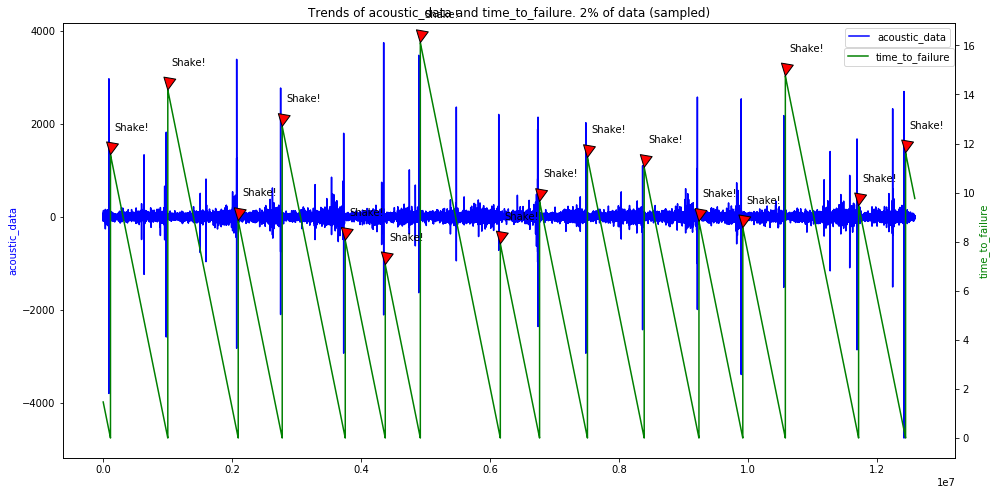

In [95]:
def plot(df_train):
    train_acoustic_data_small = df_train['acoustic_data'].values[::50]
    train_time_to_failure_small = df_train['time_to_failure'].values[::50]

    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
    plt.plot(train_acoustic_data_small, color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])

    ax2 = ax1.twinx()
    plt.plot(train_time_to_failure_small, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    for x in shake_points:
        x = x // 50 + 1
        y = train_time_to_failure_small[x]
        ax2.annotate(
            'Shake!', xy=(x, y), xytext=(x+60000, y+1),
            arrowprops=dict(facecolor='red', shrink=0.5),
        )
    plt.legend(['time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

    del train_acoustic_data_small
    del train_time_to_failure_small

plot(df_train)

In [ ]:
def plot(df_train):
    N = 200000000
    SPIKE_PEEK_THRES = 500
    SPIKE_LOCAL_RANGE = 100
    SPIKE_LOCAL_AMP = 100
    train_acoustic_data_small = df_train['acoustic_data'].values[:N:50]
    train_time_to_failure_small = df_train['time_to_failure'].values[:N:50]

    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
    plt.plot(train_acoustic_data_small, color='b')
    ax1.set_ylabel('acoustic_data', color='b')

    for x in np.where(train_acoustic_data_small > SPIKE_PEEK_THRES)[0]:
        y = train_acoustic_data_small[x]
        local = train_acoustic_data_small[x-SPIKE_LOCAL_RANGE:x+SPIKE_LOCAL_RANGE]
        if local.max() != y or local.min() * 100 > y:
            continue
        ax1.annotate(
            'Spike!', xy=(x, y), xytext=(x+60000, y+100),
            arrowprops=dict(facecolor='red', shrink=0.5),
        )
    plt.legend(['acoustic_data'])
    
    ax2 = ax1.twinx()
    plt.plot(train_time_to_failure_small, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend(['time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

    del train_acoustic_data_small
    del train_time_to_failure_small

plot(df_train)

In [ ]:
P = 104677356
W = 2000000

train_acoustic_data_small = df_train['acoustic_data'].values[P-W:P+W:50]
train_time_to_failure_small = df_train['time_to_failure'].values[P-W:P+W:50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])

ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

In [ ]:
train_time_to_failure_roll = np.roll(df_train.time_to_failure.values[5000000:6000000], 10000)

train_time_to_failure_small = df_train.time_to_failure.values[5100000:6000000]
train_time_to_failure_roll_small = train_time_to_failure_roll[100000:1000000]

#train_time_to_failure_small = df_train.time_to_failure.values[100000:1950000:20]
#train_time_to_failure_small_behind = np.roll(train_time_to_failure_small, -10000)
#train_time_to_failure_small_diff = train_time_to_failure_small - train_time_to_failure_small_behind

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.plot(train_time_to_failure_small, color='g')
plt.plot(train_time_to_failure_roll_small, color='r')
plt.plot(train_time_to_failure_small - train_time_to_failure_roll_small, color='b')

In [ ]:
train_acoustic_data_roll = np.roll(df_train.acoustic_data.values[5000000:6000000], 10000)

train_acoustic_data_small = df_train.acoustic_data.values[5100000:6000000]
train_acoustic_data_roll_small = train_acoustic_data_roll[100000:1000000]

#train_time_to_failure_small = df_train.time_to_failure.values[100000:1950000:20]
#train_time_to_failure_small_behind = np.roll(train_time_to_failure_small, -10000)
#train_time_to_failure_small_diff = train_time_to_failure_small - train_time_to_failure_small_behind

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')

ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')

plt.grid(False)
#plt.plot(train_time_to_failure_roll_small, color='r')
#plt.plot(train_time_to_failure_small - train_time_to_failure_roll_small, color='b')